# Project 3: Poisonous Mushrooms

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 examples, where each describes a mushroom by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. The feature space has been binarized. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using k-means and density estimation with Gaussian mixture models (GMM). Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please **prepare your own write-up and write your own code**.

In [3]:
%matplotlib inline

import urllib.request as urllib2 # For python3
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm

In [4]:
MUSHROOM_DATA = 'https://raw.githubusercontent.com/UCB-MIDS/207-Applied-Machine-Learning/master/Data/mushroom.data'
MUSHROOM_MAP = 'https://raw.githubusercontent.com/UCB-MIDS/207-Applied-Machine-Learning/master/Data/mushroom.map'

Load feature names.

In [5]:
feature_names = []

for line in urllib2.urlopen(MUSHROOM_MAP):
    [index, name, junk] = line.decode('utf-8').split()
    feature_names.append(name)

print('Loaded feature names: ', len(feature_names))
print(feature_names)

Loaded feature names:  126
['cap-shape=bell', 'cap-shape=conical', 'cap-shape=convex', 'cap-shape=flat', 'cap-shape=knobbed', 'cap-shape=sunken', 'cap-surface=fibrous', 'cap-surface=grooves', 'cap-surface=scaly', 'cap-surface=smooth', 'cap-color=brown', 'cap-color=buff', 'cap-color=cinnamon', 'cap-color=gray', 'cap-color=green', 'cap-color=pink', 'cap-color=purple', 'cap-color=red', 'cap-color=white', 'cap-color=yellow', 'bruises?=bruises', 'bruises?=no', 'odor=almond', 'odor=anise', 'odor=creosote', 'odor=fishy', 'odor=foul', 'odor=musty', 'odor=none', 'odor=pungent', 'odor=spicy', 'gill-attachment=attached', 'gill-attachment=descending', 'gill-attachment=free', 'gill-attachment=notched', 'gill-spacing=close', 'gill-spacing=crowded', 'gill-spacing=distant', 'gill-size=broad', 'gill-size=narrow', 'gill-color=black', 'gill-color=brown', 'gill-color=buff', 'gill-color=chocolate', 'gill-color=gray', 'gill-color=green', 'gill-color=orange', 'gill-color=pink', 'gill-color=purple', 'gill-col

Load data. The dataset is sparse, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [6]:
X, Y = [], []

for line in urllib2.urlopen(MUSHROOM_DATA):
    items = line.decode('utf-8').split()
    Y.append(int(items.pop(0)))
    x = np.zeros(len(feature_names))
    for item in items:
        feature = int(str(item).split(':')[0])
        x[feature] = 1
    X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print(train_data.shape, test_data.shape)

(7000, 126) (1124, 126)


### Part 1:

Do a principal components analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 2, 3, 4, 5, 10, 20, 30, 40, 50].  Also show a lineplot of fraction of total variance vs. number of principal components, for all possible numbers of principal components.

Notes:
* You can use `PCA` to produce a PCA analysis.

Total explained variance ratio for 1 features is 0.1640433127933419
Total explained variance ratio for 2 features is 0.29727810148780875
Total explained variance ratio for 3 features is 0.39901266670913155
Total explained variance ratio for 4 features is 0.46964623105107994
Total explained variance ratio for 5 features is 0.5083126897865482
Total explained variance ratio for 10 features is 0.652214037153078
Total explained variance ratio for 20 features is 0.8089047594529931
Total explained variance ratio for 30 features is 0.8984095039281919
Total explained variance ratio for 40 features is 0.9509211278840921
Total explained variance ratio for 50 features is 0.982102822549369


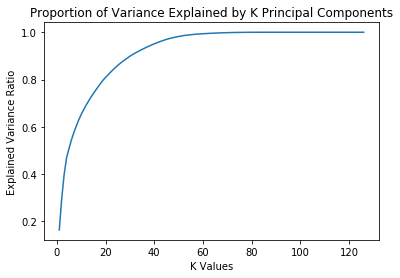

In [7]:
def P1():
    """Run PCA for various numbers of principal components. List and 
    visualize the fraction of variance accounted for by each number 
    of principal components"""
    
    #Create containers for sample k values and explained variance fraction
    k_values = [1,2,3,4,5,10,20,30,40,50]
    explained_variance = []
        
    #Generat a PCA for each k value and print the fraction of explained variance
    for k in k_values:
        pca = PCA(n_components=k)
        pca.fit(train_data)
        print("Total explained variance ratio for",k,"features is",sum(pca.explained_variance_ratio_))
    
    #Reassign the list of k values to span the entire range of features in the dataset
    k_values = list(range(1,train_data.shape[1]+1))
    
    #Generate a PCA for each k value and store it in explained_variance
    for k in k_values:
        pca = PCA(n_components=k)
        pca.fit(train_data)
        explained_variance.append(sum(pca.explained_variance_ratio_))
        
    #Plot k values vs. explained variance ratio
    plt.plot(k_values, explained_variance)
    plt.title("Proportion of Variance Explained by K Principal Components")
    plt.xlabel("K Values")
    plt.ylabel("Explained Variance Ratio")

P1()

### Part 2:

PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and show as a square scatterplot. Show the positive (poisonous) examples in red and the negative (non-poisonous) examples in green. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

Notes:
* You can use `PCA` to produce a PCA analysis.

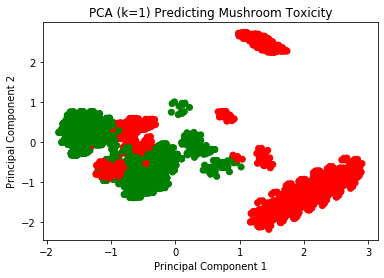

In [8]:
def P2():
    """Project the training data down to two dimensions and visualize it 
    in a color-coded scatter plot"""
    
    #Create a PCA with 2 components adn fit it to the training data
    pca = PCA(n_components=2)
    components = pca.fit_transform(train_data)
    
    #Color code the training data by label. Red for poisonous, 
    #green for non-poisonous
    colors = []
    for i in train_labels:
        if i == 0:
            colors.append('g')
        if i == 1:
            colors.append('r')
    
    #Plot the projected data
    plt.scatter(components[:,0],components[:,1],c=colors)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title("PCA (k=1) Predicting Mushroom Toxicity")
    



P2()

### Part 3:

Fit a k-means cluster model with 6 clusters over the 2d projected data. As in part 2, show as a square scatterplot with the positive (poisonous) examples in red and the negative (non-poisonous) examples in green.  For each cluster, mark the centroid and plot a circle that goes through the cluster's example that is most distant from the centroid.

Notes:
* You can use `KMeans` to produce a k-means cluster analysis.
* You can use `linalg.norm` to determine distance (dissimilarity) between observations.

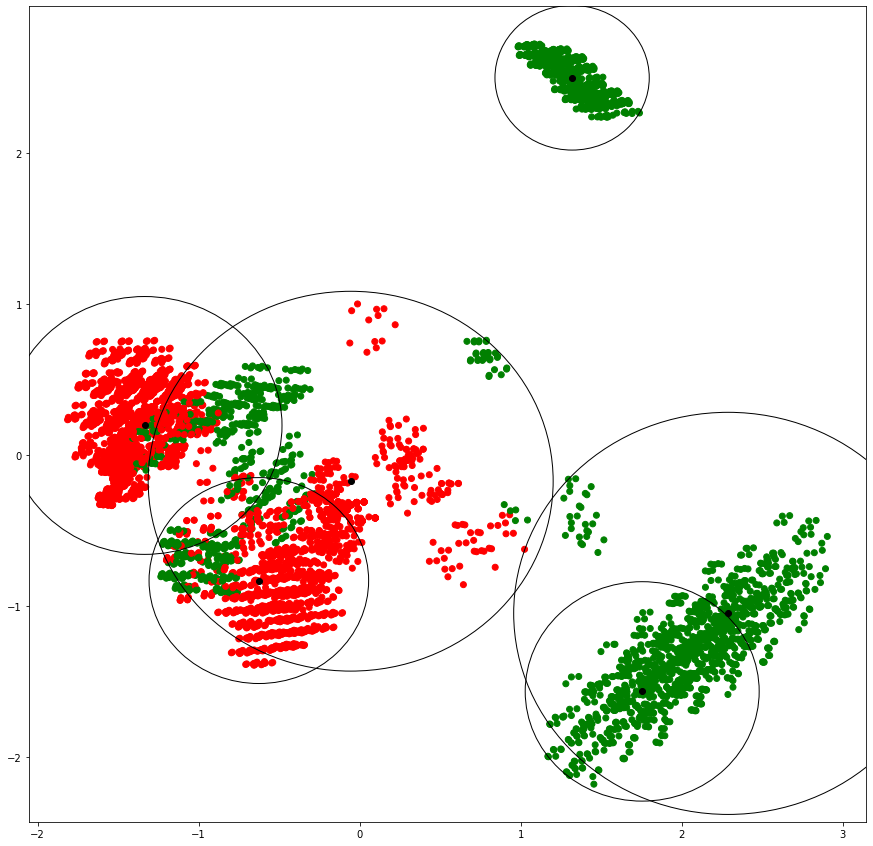

In [9]:
def P3():
    """Fit a 6-cluster k-means model to the 2d projected data. Create a 
    color-coded scatter plot with centroids indentified and furthest 
    outliers centered"""
    
    #Fit a 2-component PCA to the training data
    pca = PCA(n_components=2)
    pca_dat = pca.fit_transform(train_data)
    
    #Create a k-means model with 6 clusters and fit it to the PCA data
    km = KMeans(n_clusters=6)
    km.fit(pca_dat)
    
    #Predict on the PCA data
    pred = km.predict(pca_dat)
    
    #Extract centroids
    centroids = km.cluster_centers_
    
    #Identify furthest outlier for each cluster
    max_dist = []
    for i in range(6):
        clstr_dat = pca_dat[pred==i]
        cent = centroids[i]
        
        dmax = 0
        
        for j in clstr_dat:
            dist = np.linalg.norm(j-cent)
            if dist > dmax:
                dmax = dist
                point = j
        
        max_dist.append(dmax)
    
    #Color code the training data by label. Red for poisonous, 
    #green for non-poisonous
    colors = []
    for i in train_labels:
        if i == 0:
            colors.append('r')
        if i == 1:
            colors.append('g')
    
    fig, ax = plt.subplots(figsize=(15,15))

    #Plot the color-coded training data
    ax.scatter(pca_dat[:,0],pca_dat[:,1],c=colors,)
    
    #Plot the cluster centroids
    ax.scatter(centroids[:,0],centroids[:,1],color='black')
    
    #Plot the circles
    #https://stackoverflow.com/questions/9215658/plot-a-circle-with-pyplot
    for i in range(6):
        circ = plt.Circle(centroids[i],radius=max_dist[i], fill=False)
        ax.add_patch(circ)


P3()

### Part 4:

Fit Gaussian mixture models for the positive (poisonous) examples in your 2d projected data. Vary the number of mixture components from 1 to 4 and the covariance matrix type 'spherical', 'diag', 'tied', 'full' (that's 16 models).  Show square plots of the estimated density contours presented in a 4x4 grid - one row each for a number of mixture components and one column each for a convariance matrix type.  

Notes:
* You can use `GaussianMixture(n_components=..., covariance_type=..., random_state=12345)` to produce a Gaussian mixture model.
* You can use `contour` in combination with other methods to plot contours, like in this example: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py
* You can use `contour` without the `norm` and `levels` parameters. 

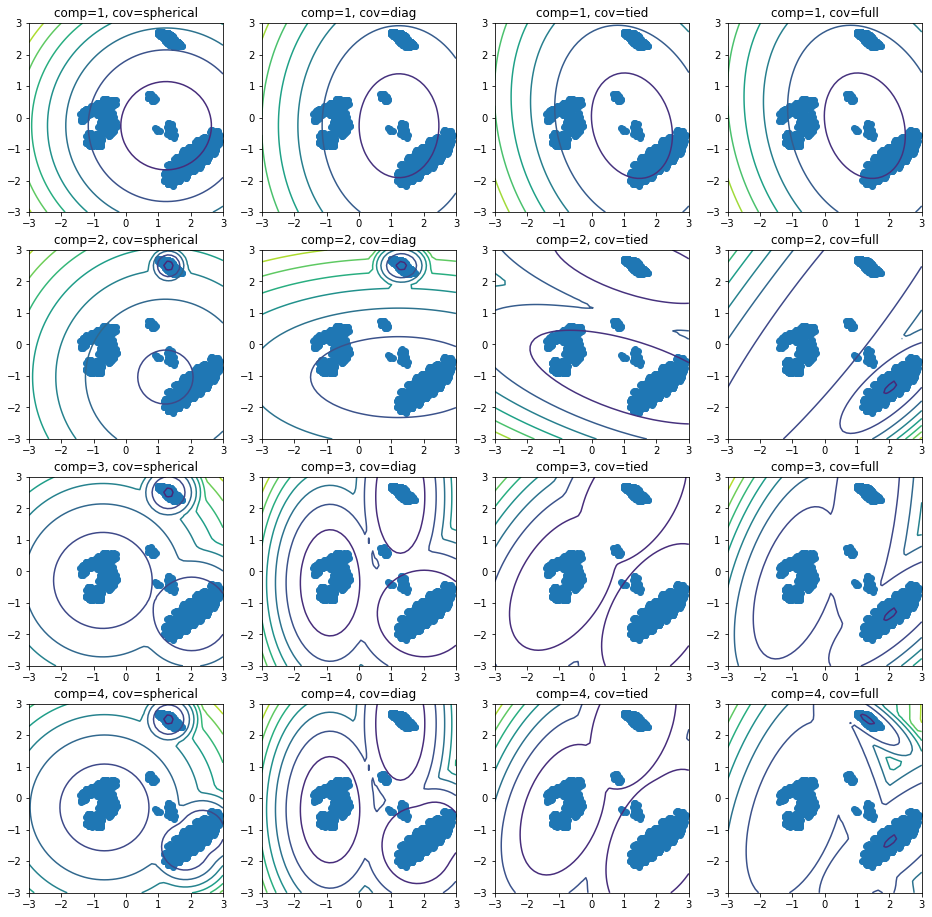

In [10]:
def P4():
    """Create contour plots for GM Models of varying component 
    counts and covariance types"""

    
    #2D Principal Component Analysis
    pca = PCA(n_components=2)
    pca_dat = pca.fit_transform(train_data)[train_labels==1]
    
    #Isolate only poisonous data
    pois_dat = []
    for i in range(len(train_data[train_labels==1])):
        if train_labels[i] == 1:
            pois_dat.append(pca_dat[i])
    
    pois_dat = np.array(pois_dat)
    
    fig, axs = plt.subplots(4,4,figsize=(16,16))
            
    cov = ['spherical','diag','tied','full']
    comp = list(range(1,5))
    #Gaussian Mixture Model with 1-4 components, and each covariance matrix type
    for i in range(4):
        for j in range(4):
            
            gm = GaussianMixture(n_components=comp[i], covariance_type=cov[j] ,random_state=12345)
            gm.fit(pois_dat)
            
            #Lines 33-38 derived heavily from sklearn's user guide "Density Estimation for a Gaussian Mixture"
            #https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#sphx-glr-auto-examples-mixture-plot-gmm-pdf-py
            x = np.linspace(-3., 3.)
            y = np.linspace(-3., 3.)
            X, Y = np.meshgrid(x, y)
            XX = np.array([X.ravel(), Y.ravel()]).T
            Z = -gm.score_samples(XX)
            Z = Z.reshape(X.shape)
            
            axs[i,j].contour(X,Y,Z)
            axs[i,j].scatter(pca_dat[:,0],pca_dat[:,1])
            axs[i,j].set_title("comp="+str(comp[i])+", cov="+str(cov[j]))
    
    plt.show()

P4()

### Part 5:

Fit two Gaussian mixture models, one for the positive examples and one for the negative examples in your 2d projected data. Use 4 mixture components and full convariance for each model.  Predict the test example labels by picking the labels corresponding to the larger of the two models' probabilities.  What is the accuracy of you predictions on the test data?

Notes:
* You can use `GaussianMixture(n_components=..., covariance_type=..., random_state=12345)` to produce a Gaussian mixture model.
* You can use `GaussianMixture`'s `score_samples` method to find the probabilities.

In [11]:
def P5(pca_n=2,gmm_n=4,cov_typ='full'):
    """Generate two GMM models, one for positive examples and one for negative 
    examples and calculate the accuracy of using both in tandem"""
    
    #Generate 2D PCA
    pca = PCA(n_components=pca_n)
    pca_dat = pca.fit_transform(train_data)
    pca_test = pca.transform(test_data)
    
    #Generate 2 GMM models, one for positive data, one for negative
    gm_pos = GaussianMixture(n_components=gmm_n,covariance_type=cov_typ,random_state=12345)
    gm_neg = GaussianMixture(n_components=gmm_n,covariance_type=cov_typ,random_state=12345)
    
    #Separate data into positive and negative values
    pos_dat = pca_dat[train_labels==1]
    neg_dat = pca_dat[train_labels==0]
    
    #Fit the two GMM models
    gm_pos.fit(pos_dat)
    gm_neg.fit(neg_dat)
    
    #Calculate log liklihood using both models
    pos_pred = gm_pos.score_samples(pca_test)
    neg_pred = gm_neg.score_samples(pca_test)
    
    #Label determination
    pred = (pos_pred > neg_pred) * 1
    
    #Calculate accuracy
    count_matches = np.sum((pred==test_labels)*1)
    acc = count_matches/pred.shape[0]
    
    return acc
    
    
    

P5()

0.9501779359430605

### Part 6:

Run a series of experiments to find the Gaussian mixture model that results in the best accuracy with no more than 50 parameters.  Do this by varying the number of PCA components, the number of GMM components, and the covariance type.

Notes:
* You can use `GaussianMixture(n_components=..., covariance_type=..., random_state=12345)` to produce a Gaussian mixture model.


* For spherical, diag, and full covariance types:
  * number of parameters = (number of parameters per gmm component * number of gmm components - 1) * number of classes
  * number of parameters per gmm component includes all the means plus all the non-zero, non-duplicated values in the covariance matrix plus the mixing weight
  * Each mixing weight parameter indicates how much to weight a particular gmm component; the -1 above accounts for the fact that the mixing weights must sum to 1, so you do not need to include the last mixing weight as its own parameter


* To calculate the number of parameters for tied covariance type:
  * number of parameters = (number of parameters per class - 1) * number of classes
  * number of parameters per class includes all the means and mixing weights for all the gmm components plus all the non-zero, non-duplicated values in the one shared covariance matrix
  * Each mixing weight parameter indicates how much to weight a particular gmm component; the -1 above accounts for the fact that the mixing weights must sum to 1, so you do not need to include the last mixing weight as its own parameter

In [18]:
def P6(pca_n=10,gmm_n=5,cov=['spherical','diag','tied','full']):
    """Iterate through many models to maximize accuracy"""
    accuracies = []
    for i in range(1,pca_n+1):
        for j in range(1,gmm_n+1):
            for k in cov:
                #Calculate Number of Parameters in GMM Model
                if k == 'spherical':
                    n_params = (i*j+j)*2
                elif k == 'diag':
                    n_params = (i*j + i*j)*2
                elif k in 'tied':
                    n_params = (i*j + i*(i+1)/2)*2
                elif k == 'full':
                    n_params = (i*j + i*(i+1)/2*j)*2
                
                #Run GMM Model using P5
                if n_params < 50:
                    acc = P5(pca_n=i,gmm_n=j,cov_typ=k)
                    accuracies.append((acc,i,j,k,n_params))
    
    accuracies.sort()
    
    print("Top 10 Highest Performing Models")
    for i in range(len(accuracies)-1,len(accuracies)-10,-1):
        print("PCA Components=", accuracies[i][1],
              "GMM Components=",accuracies[i][2],
              "Covariance Type=", accuracies[i][3],
              "Total Components =", accuracies[i][4],
              "Accuracy=", accuracies[i][0])
    
P6()

Top 10 Highest Performing Models
PCA Components= 7 GMM Components= 3 Covariance Type= spherical Total Components = 48 Accuracy= 0.9733096085409253
PCA Components= 6 GMM Components= 2 Covariance Type= diag Total Components = 48 Accuracy= 0.9733096085409253
PCA Components= 7 GMM Components= 2 Covariance Type= spherical Total Components = 32 Accuracy= 0.9715302491103203
PCA Components= 4 GMM Components= 3 Covariance Type= tied Total Components = 44.0 Accuracy= 0.9697508896797153
PCA Components= 10 GMM Components= 2 Covariance Type= spherical Total Components = 44 Accuracy= 0.9688612099644128
PCA Components= 8 GMM Components= 2 Covariance Type= spherical Total Components = 36 Accuracy= 0.9688612099644128
PCA Components= 6 GMM Components= 3 Covariance Type= spherical Total Components = 42 Accuracy= 0.9679715302491103
PCA Components= 9 GMM Components= 2 Covariance Type= spherical Total Components = 40 Accuracy= 0.9661921708185054
PCA Components= 5 GMM Components= 3 Covariance Type= spherical